### Notebook to compare NEST recombination models to Box and Birks dE/dx models

In [1]:
import larnestpy
import numpy as np
import matplotlib.pyplot as plt
from math import log, isnan
from scipy import integrate

In [2]:
def box(dEdx):
    # Baller, 2013 JINST 8 P08005
    box_beta = 0.207
    efield = 0.5 # kV/cm
    rho = 1.393 # g/cm^3
    box_alpha = 0.93
    csi = box_beta * dEdx / (efield * rho)
    recomb = max(0, log(box_alpha + csi)/csi)
    return recomb

def birks(dEdx):
    # Amoruso, et al NIM A 523 (2004) 275
    birks_Ab = 0.800
    birks_kb = 0.0486
    rho = 1.393 # g/cm^3
    efield = 0.5 # kV/cm
    recomb = birks_Ab / (1 + birks_kb * dEdx / (efield * rho))
    return recomb

def ER(E):
    dx = 0.01
    efield = 0.5 # kV/cm
    rho = 1.393 # g/cm^3
    calc = larnestpy.LArNEST()
    result = calc.full_calculation(larnestpy.LArInteraction.ER, E, dx, efield*1e3, rho, False)
    recomb = result.yields.RecombinationProbability
    return recomb

def NR(E):
    dx = 0.01
    efield = 0.5 # kV/cm
    rho = 1.393 # g/cm^3
    calc = larnestpy.LArNEST()
    result = calc.full_calculation(larnestpy.LArInteraction.NR, E, dx, efield*1e3, rho, False)
    recomb = result.yields.RecombinationProbability
    return recomb

def LArNEST_dEdx(E):
    dx = 0.001
    efield = 0.5 # kV/cm
    rho = 1.393 # g/cm^3
    calc = larnestpy.LArNEST()
    result = calc.full_calculation(larnestpy.dEdx, E, dx, efield*1e3, rho, False)
    recomb = result.yields.RecombinationProbability
    return recomb

def alpha(E):
    dx = 0.001
    efield = 0.5 # kV/cm
    rho = 1.393 # g/cm^3
    calc = larnestpy.LArNEST()
    result = calc.full_calculation(larnestpy.Alpha, E, dx, efield*1e3, rho, False)
    #recomb = result.yields.Ne / (result.yields.Ne + result.yields.Nph)
    recomb = result.yields.RecombinationProbability
    return recomb

In [20]:
def extract_data(file_path):
    kinetic_energy = []
    collision_stp_pow = []

    with open(file_path, 'r') as file:
        for i, line in enumerate(file):
            if i < 8:  # Skip the first 8 lines
                continue
            parts = line.split()  # Split the line into parts
            kinetic_energy.append(float(parts[0]))
            collision_stp_pow.append(float(parts[1]))

    # Convert the lists to numpy arrays
    kinetic_energy = np.array(kinetic_energy)
    collision_stp_pow = np.array(collision_stp_pow)

    return kinetic_energy, collision_stp_pow
# NIST values from physics.nist.gov
energies, collision_stp_pow = extract_data('NIST_stopping_power.txt')

# get recombination probabilities from LArNEST models
recomb_values_ER = np.zeros_like(energies)
recomb_values_NR = np.zeros_like(energies)
recomb_values_LArNESTdEdx = np.zeros_like(energies)
recomb_values_alpha = np.zeros_like(energies)

for i, energy in enumerate(energies):
    recomb_values_ER[i] = ER(energy*1e3)
    recomb_values_NR[i] = NR(energy*1e3)
    recomb_values_LArNESTdEdx[i] = LArNEST_dEdx(energy*1e3)
    recomb_values_alpha[i] = alpha(energy*1e3)
    
# get recombination probabilities from box and birks models, using NIST dE/dx values
recomb_values_box = np.zeros_like(energies)
recomb_values_birks = np.zeros_like(energies)
density = 1.393
for i, dEdx in enumerate(collision_stp_pow):
    recomb_values_box[i] = box(dEdx*density)
    recomb_values_birks[i] = birks(dEdx*density)
    #recomb_values_box[i] = box(energies[i]/1)
    #recomb_values_birks[i] = birks(energies[i]/1)

Text(0.5, 1.0, 'Recombination Probability vs Energy Model Comparison')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
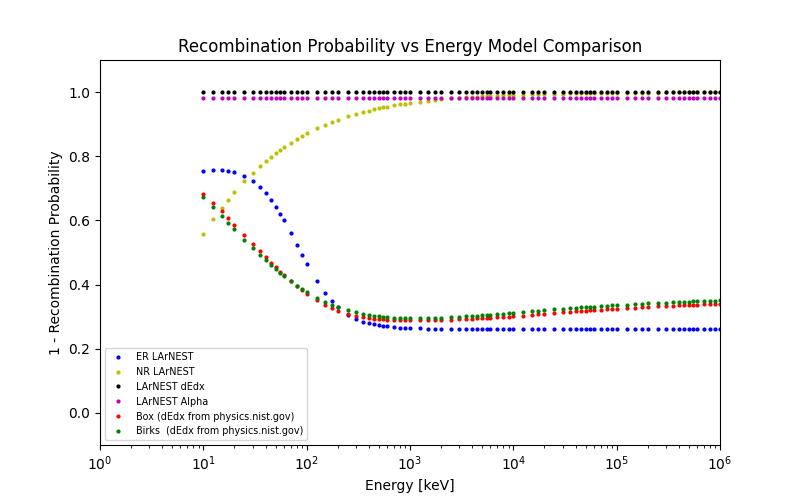

In [21]:
%matplotlib widget
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False, figsize=(8,5))
axes.plot(energies*1e3, recomb_values_ER, 'bo', markersize = 2, label='ER LArNEST')
axes.plot(energies*1e3, recomb_values_NR, 'yo', markersize = 2, label='NR LArNEST')
axes.plot(energies*1e3, recomb_values_LArNESTdEdx, 'ko', markersize = 2, label='LArNEST dEdx')
axes.plot(energies*1e3, recomb_values_alpha, 'mo', markersize = 2, label='LArNEST Alpha')
axes.plot(energies*1e3, 1-recomb_values_box, 'ro', markersize = 2, label='Box (dEdx from physics.nist.gov)')
axes.plot(energies*1e3, 1-recomb_values_birks, 'go', markersize = 2, label='Birks  (dEdx from physics.nist.gov)')
#axes.set_yscale('log')
axes.set_xlabel('Energy [keV]')
axes.set_ylabel('1 - Recombination Probability')
axes.set_xscale('log')
axes.set_xlim(1, 1e6)
axes.set_ylim(-0.1,1.1)
axes.legend(fontsize='x-small')
axes.set_title('Recombination Probability vs Energy Model Comparison')

Text(0.5, 1.0, 'Recombination Probability vs dE/dx Model Comparison')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
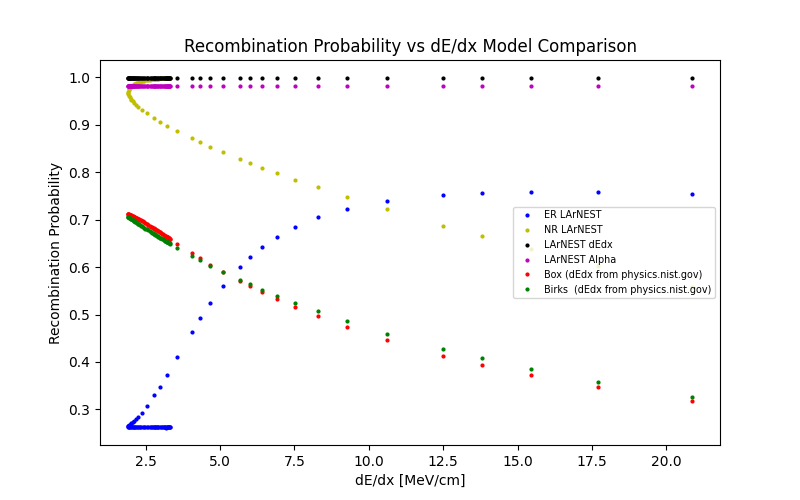

In [25]:
%matplotlib widget
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=False, sharey=False, figsize=(8,5))
axes.plot(collision_stp_pow*density, recomb_values_ER, 'bo', markersize = 2, label='ER LArNEST')
axes.plot(collision_stp_pow*density, recomb_values_NR, 'yo', markersize = 2, label='NR LArNEST')
axes.plot(collision_stp_pow*density, recomb_values_LArNESTdEdx, 'ko', markersize = 2, label='LArNEST dEdx')
axes.plot(collision_stp_pow*density, recomb_values_alpha, 'mo', markersize = 2, label='LArNEST Alpha')
axes.plot(collision_stp_pow*density, recomb_values_box, 'ro', markersize = 2, label='Box (dEdx from physics.nist.gov)')
axes.plot(collision_stp_pow*density, recomb_values_birks, 'go', markersize = 2, label='Birks  (dEdx from physics.nist.gov)')
#axes.set_yscale('log')
axes.set_xlabel('dE/dx [MeV/cm]')
axes.set_ylabel('Recombination Probability')
#axes.invert_xaxis()
#axes.set_xscale('log')
#axes.set_xlim(1.5, 5)
#axes.set_ylim(-0.1,1.1)
axes.legend(fontsize='x-small')
axes.set_title('Recombination Probability vs dE/dx Model Comparison')